# Continuous Wavelet Transform (CWT) on CWRU Bearing Data

**Datasets** : CWRU bearing vibration data (Normal_0 vs IR007_0)


## 1. Import libraries

In [1]:
import numpy as np
import scipy.io as sio
import pywt
import matplotlib.pyplot as plt

## 2. Load CWRU vibration signal

In [2]:
def load_cwru_signal(mat_path, signal_key, length=4096):
    mat = sio.loadmat(mat_path)
    signal = mat[signal_key].squeeze()
    signal = signal[:length]
    signal = (signal - np.mean(signal)) / np.std(signal)
    return signal

Now load both conditions:

In [3]:
normal_signal = load_cwru_signal(
    'datasets/cwru/Normal_0.mat',
    'X097_DE_time'                   # 'X097_DE_time', 'X097_FE_time', 'X097RPM'
)

ir007_signal = load_cwru_signal(
    'datasets/cwru/IR007_0.mat',
    'X105_DE_time'                  # 'X105_DE_time', 'X105_FE_time', 'X105_BA_time', 'X105RPM'
)

## 3. Mother wavelet preparation
The mother wavelet must be selected because it determines how well the transform matches the signal characteristics, directly affecting time-frequency resolution and fault feature visibility.

> *Note: For rotating machinery vibration signals, the Morlet wavelet is commonly selected because its oscillatory shape closely matches mechanical vibration and provides clear fault-related patterns*

**Summary**
| Wavelet | Type | Oscillatory | Time Localization | Frequency Localization | Typical Use |
|-------|------|------------|-------------------|------------------------|------------|
| morl  | Real Morlet | Yes | High | High | Bearing & gear faults |
| cmor  | Complex Morlet | Yes | Medium | Very High | Frequency tracking |
| mexh  | Mexican Hat | No | Very High | Low | Impulse detection |
| gaus | Gaussian Derivative | No | Very High | Low | Shock / edge detection |
| paul | Paul | Yes | High | Medium | Envelope modulation |
| shan | Shannon | Yes | Low | Very High | Frequency separation |
| fbsp | B-spline | Yes | Medium | High | Research analysis |

In [4]:
wavelet = 'morl'    # Morlet wavelet

## 4. Scaling loop
The scaling loop in CWT stretches and compresses the mother wavelet over a continuous range of scales, enable detailed analysis of signal similarity across both time and frequency.

Although scales are user-defined, their selection should consider the signal sampling frequency, target fault frequencies, and wavelet center frequency to ensure meaningful physical interpretation.

In [5]:
scales = np.arange(1, 129)

## 5. Convolution Step

To compute the time-scale representation of the signal by correlating it with scaled versions of the mother wavelet.

**What happens internally?**
- Wavelet scaling
    - The mother wavelet is stretched or compressed according to each scale
- Convolution operation
    - Each scaled wavelet is slid across the signal
    - A similarity score is computed at every time point
- Efficient computation
    - FFT-based convolution is automatically applied for speed

In [6]:
coeffs_N, freqs_N = pywt.cwt(
    normal_signal,
    scales,
    wavelet,
    sampling_period=1.0
)

coeffs_I, freqs_I = pywt.cwt(
    ir007_signal,
    scales,
    wavelet,
    sampling_period=1.0
)

## 6. CWT Coefficient Interpretation
To understand the meaning of the coefficient produced by the CWT.

**How to interprete coefficient values***

| Observation | Interpretation |
| -------- | -------- |
| Large magnitude | Strong presence of that frequency |
| Small magnitude | Weak or no presence |
| Veritcal energy streaks | Impulsive faults |
| Horizontal ridges | Persistent harmonic components |


In [8]:
print(coeffs_N.shape)

(128, 4096)


## 7. Scalogram construct (Time-scale energy map)

**What you should observe**
- Normal
    - Smooth energy distribution
    - Dominant low-frequency components
- IR007 Fault
    - Hight-energy bursts
    - Strong high-frequency components (impulses)
    - Clear non-stationary behavior

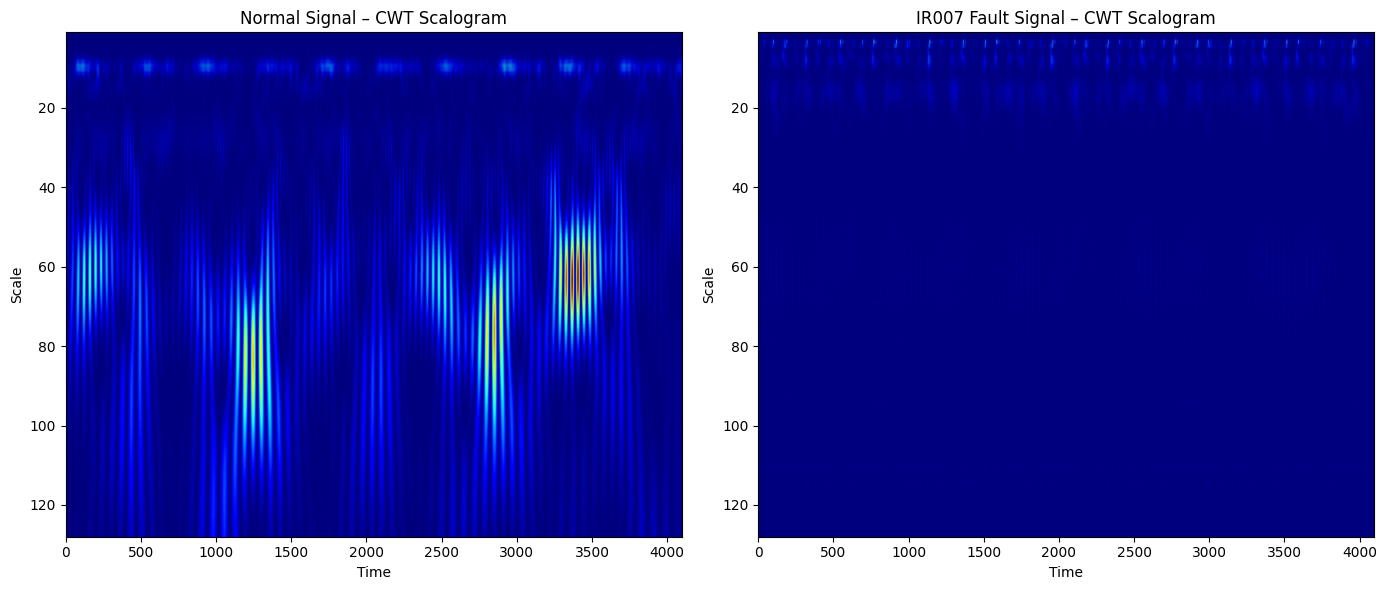

In [11]:
energy_N = np.abs(coeffs_N) ** 2
energy_I = np.abs(coeffs_I) ** 2

# Visualization: Normal vs Fault
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(
    energy_N,
    extent=[0, len(normal_signal), scales[-1], scales[0]],
    aspect='auto',
    cmap='jet'
)
plt.title('Normal Signal – CWT Scalogram')
plt.xlabel('Time')
plt.ylabel('Scale')

plt.subplot(1, 2, 2)
plt.imshow(
    energy_I,
    extent=[0, len(ir007_signal), scales[-1], scales[0]],
    aspect='auto',
    cmap='jet'
)
plt.title('IR007 Fault Signal – CWT Scalogram')
plt.xlabel('Time')
plt.ylabel('Scale')

plt.tight_layout()
plt.show()

## 8. Frequency Mapping

- Converts abstract scale values to physical frequency (Hz)
- Enables fault frequency interpretation (BPFO, BPFI, etc.)

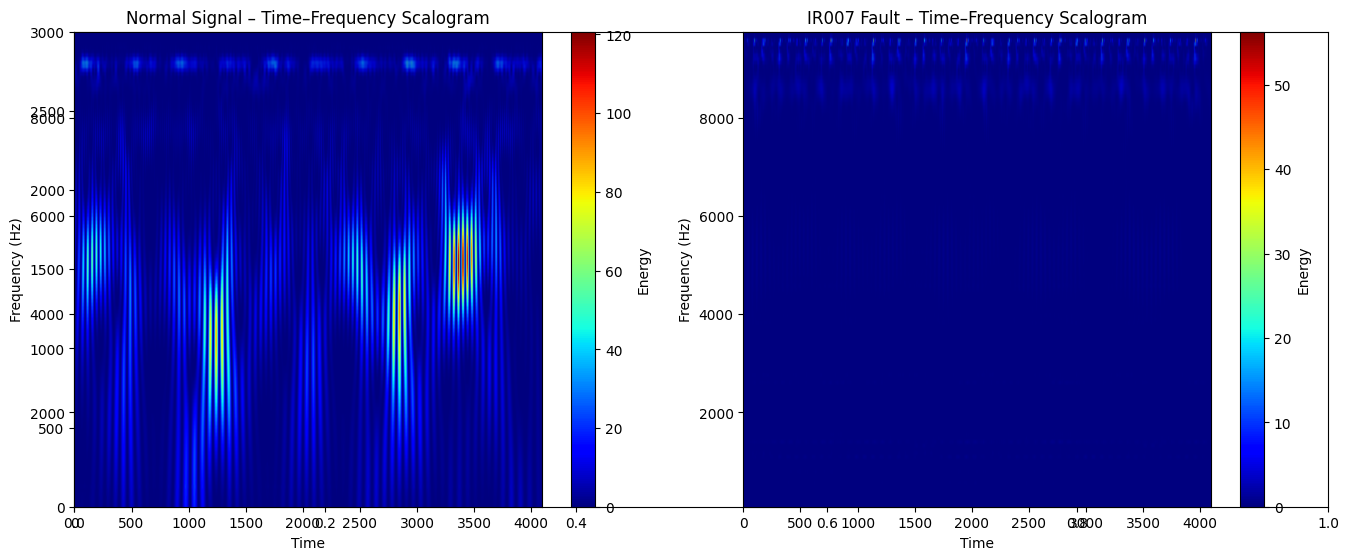

In [ ]:
sampling_frequency = 12000  # Hz (CWRU DE signal)

frequencies = pywt.scale2frequency(wavelet, scales) * sampling_frequency

# Visualize: Normal vs IR007
plt.figure(figsize=(14, 6))

# Normal signal
plt.subplot(1, 2, 1)
plt.imshow(
    energy_N,
    extent=[0, len(normal_signal), frequencies[-1], frequencies[0]],
    aspect='auto',
    cmap='jet'
)
plt.title('Normal Signal – Time–Frequency Scalogram')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Energy')

# IR007 fault signal
plt.subplot(1, 2, 2)
plt.imshow(
    energy_I,
    extent=[0, len(ir007_signal), frequencies[-1], frequencies[0]],
    aspect='auto',
    cmap='jet'
)
plt.title('IR007 Fault – Time–Frequency Scalogram')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Energy')

plt.tight_layout()
plt.show()

## Flow Chart

In [1]:
from mermaid import Mermaid

Mermaid("""
graph TD
    A[Original Signal] --> B{Scaling Loop}
    
    B -->|Scale a1| C[Scaled Wavelet]
    B -->|Scale a2| D[Scaled Wavelet]
    B -->|Scale aN| E[Scaled Wavelet]
    
    C --> F[Convolution]
    D --> F
    E --> F
    
    F --> G["CWT Coefficients Matrix"]
    
    G --> H["Energy Computation"]
    H --> I[Time–Scale Scalogram]
    
    I --> J[Scale → Frequency Mapping]
    J --> K[Time–Frequency Scalogram]
""")